# Welcome to Assignment 6
# Sha Liu


### Q1. Compare PageRank distribution
**Please read `retweet-digraph.edges` as a directed and unweighted network.**  
1. Compute the PageRank distribution over all nodes.
2. Select all nodes with in-degree 3 and compute their PageRank distribution. How does it compare with the global distribution of PageRank that we calculated above?
3. Plot the average PageRank as a function of in-degree. For that, divide all nodes in in-degree class, where each class includes all nodes with the same in-degree. Compute the average value of PageRank for all nodes in the same class, and plot the average value as a function of in-degree. 

hint: 
please use nx.read_weighted_edgelist() first, but don't use the "weight" when calculating PageRank.

In [1]:
%matplotlib inline
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

G = nx.read_weighted_edgelist('data/retweet-digraph.edges',create_using=nx.DiGraph)
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 18470
Number of edges: 48365
Average in degree:   2.6186
Average out degree:   2.6186


In [2]:
# Compute the PageRank distribution over all nodes
PR_dict = nx.pagerank(G)
len(PR_dict)

18470

In [3]:
# Use statistics values to compare the distribution
import statistics
print('Mean PageRank of all nodes:', statistics.mean(PR_dict.values()))
print('Standard deviation of all nodes:',statistics.stdev(PR_dict.values()))

Mean PageRank of all nodes: 5.414185165132537e-05
Standard deviation of all nodes: 8.088666357608657e-05


In [4]:
# Select all nodes with in-degree 3 and compute their PageRank distribution
in_degree_3_sequence = [n for n in G.nodes if G.in_degree(n) == 3]
pageRank_in_degree_3_sequence = []
for n in in_degree_3_sequence:
    page_rank = PR_dict[n]
    pageRank_in_degree_3_sequence.append(page_rank)

# Use statistics values to compare the distribution
print('Mean PageRank of nodes with in-degree 3:', statistics.mean(pageRank_in_degree_3_sequence))
print('Standard deviation of nodes with in-degree 3:',statistics.stdev(pageRank_in_degree_3_sequence))

Mean PageRank of nodes with in-degree 3: 5.680615259546695e-05
Standard deviation of nodes with in-degree 3: 3.306290380322567e-05


In [5]:
statistics.mean(PR_dict.values()) < statistics.mean(pageRank_in_degree_3_sequence)

True

In [6]:
statistics.stdev(PR_dict.values()) < statistics.stdev(pageRank_in_degree_3_sequence)

False

Per above, we can see that the mean of 3 in_degrees pagerank is larger than the mean of all nodes pagerank, and the standard deviation of 3 in_degrees pagerank is smaller than the standard deviation  of all nodes pagerank.

In [7]:
# Plot the average PageRank as a function of in-degree
import pandas as pd

# create a dataframe of all nodes and in_degrees
in_degree_sequence = {n: G.in_degree(n) for n in G.nodes}
df_in_degree = pd.DataFrame(list(in_degree_sequence.items()),columns = ['node','in-degree']) 

# create a dataframe of all nodes and PageRank
df_PR = pd.DataFrame(list(PR_dict.items()),columns = ['node','PageRank']) 

# Merge these two dataframes into one that contains all nodes, PageRank, and in-degrees
df_merge = pd.merge(df_PR, df_in_degree, on='node')

# Compute the average value of PageRank for all nodes in the same class and create it as a dataframe
df_in_degree_PR = df_merge.groupby('in-degree').mean().reset_index()
df_in_degree_PR.rename(columns={'PageRank':'Avg_PageRank'}, inplace=True)
df_in_degree_PR

,in-degree,Avg_PageRank
0,0,0.000035
1,1,0.000040
2,2,0.000050
3,3,0.000057
4,4,0.000064
...,...,...
92,124,0.000664
93,137,0.001124
94,147,0.001449
95,150,0.003925


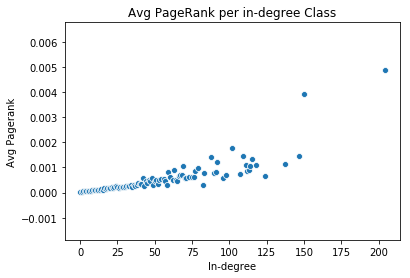

In [8]:
# plot the average value as a function of in-degree.
sns.scatterplot(x='in-degree', y='Avg_PageRank', data=df_in_degree_PR)
plt.title('Avg PageRank per in-degree Class')
plt.xlabel('In-degree')
plt.ylabel('Avg Pagerank');

### Q2. Filtering links
**Now read `c.elegans` as an undirected weighted network.**  
1. What is the Pearson correlation coefficient between the degree and the strength of the nodes?  
2. Filter the links using the backbone formula discussed in class. Use the values 0.05 and 0.01 for the threshold alpha.
Each link gives two values for the baseline probability, one for each of its endpoints. Use the smaller one.

3. What is the fraction of edges removed for threshold 0.05 and 0.01?   
4. Is the network connected after the filterings?
5. Plot the distribution of the weights and the strengths in both cases, and compare them. Explain your answer.




In [9]:
G = nx.read_weighted_edgelist('data/celegansneural.edges.txt')
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 297
Number of edges: 2148
Average degree:  14.4646


In [10]:
import scipy.stats
degree_sequence = [G.degree(n) for n in G.nodes]
strength_sequence = []
for i in G.nodes:
    strength = G.degree(i, weight = 'weight')
    strength_sequence.append(strength)
co = scipy.stats.pearsonr(degree_sequence, strength_sequence)[0]

print("Pearson correlation coefficient between the degree and the strength of the nodes is:", co)

Pearson correlation coefficient between the degree and the strength of the nodes is: 0.7902833997530194


In [11]:
def pij(i, j, G):
    ## calculate pij = min((1-wij/si)**(ki-1), (1-wij/sj)**(kj-1))
    wij = G.get_edge_data(i,j)['weight']
    
    ## (1-wij/si)**(ki-1)
    si = G.degree(i, weight='weight')
    prob_i = (1-(wij/si))**(G.degree(i)-1)
  
    ## (1-wij/sj)**(kj-1)
    sj = G.degree(j, weight='weight')
    prob_j = (1-(wij/sj))**(G.degree(j)-1)
        
    prob_ij = min(prob_i, prob_j)
    return (i, j, prob_ij)

pij_list = []
for i, j in G.edges():
    pij_list.append(pij(i,j,G))

In [12]:
# Use the values 0.05 for the threshold alpha
C1 = G.copy()
for i, j, p in pij_list:
    if p >= 0.05:
        C1.remove_edge(i, j)
print("The fraction of edges removed for threshold 0.05 is", (G.number_of_edges()-C1.number_of_edges())/G.number_of_edges())

The fraction of edges removed for threshold 0.05 is 0.9203910614525139


In [13]:
# Use the values 0.01 for the threshold alpha
C2 = G.copy()
for i, j, p in pij_list:
    if p >= 0.01:
        C2.remove_edge(i, j)
print("The fraction of edges removed for threshold 0.01 is", (G.number_of_edges()-C2.number_of_edges())/G.number_of_edges())

The fraction of edges removed for threshold 0.01 is 0.978584729981378


In [14]:
nx.is_connected(C1)

False

In [15]:
nx.is_connected(C2)

False

Therefore, both networks are not connected after the filterings

Plot the distribution of the weights and the strengths in both cases, and compare them.

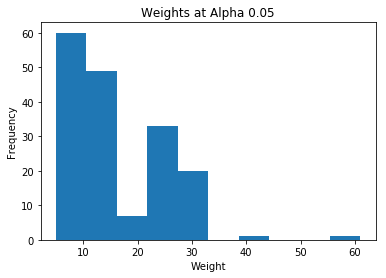

In [16]:
# C1 Weight distribution
C1_weights = []
for (i, j, w) in C1.edges(data = 'weight'):
    C1_weights.append(w)
counts, bins, patches = plt.hist(C1_weights, bins=10)
plt.title('Weights at Alpha 0.05')
plt.xlabel('Weight')
plt.ylabel('Frequency');

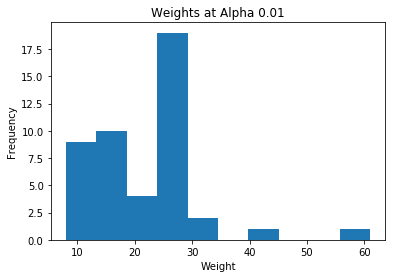

In [17]:
# C2 Weight distribution
C2_weights = []
for (i, j, w) in C2.edges(data = 'weight'):
    C2_weights.append(w)
counts, bins, patches = plt.hist(C2_weights, bins=10)
plt.title('Weights at Alpha 0.01')
plt.xlabel('Weight')
plt.ylabel('Frequency');

In [18]:
print('Mean weight of Alpha 0.05:', statistics.mean(C1_weights))
print('Standard deviation weight of Alpha 0.05:',statistics.stdev(C1_weights))

print('Mean weight of Alpha 0.01:', statistics.mean(C2_weights))
print('Standard deviation weight of Alpha 0.01:',statistics.stdev(C2_weights))

Mean weight of Alpha 0.05: 15.988304093567251
Standard deviation weight of Alpha 0.05: 8.47903178718889
Mean weight of Alpha 0.01: 22.347826086956523
Standard deviation weight of Alpha 0.01: 9.886505710769711


Per statistics shown above, when the alpha is smaller, the mean weight and the standard deviation weight are both larger.

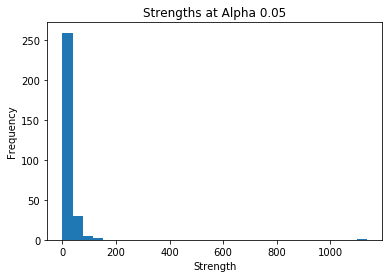

In [19]:
# C1 Strength distribution
C1_strength_sequence = []
for i in C1.nodes:
    strength = C1.degree(i, weight = 'weight')
    C1_strength_sequence.append(strength)

counts, bins, patches = plt.hist(C1_strength_sequence, bins=30)
plt.title('Strengths at Alpha 0.05')
plt.xlabel('Strength')
plt.ylabel('Frequency');

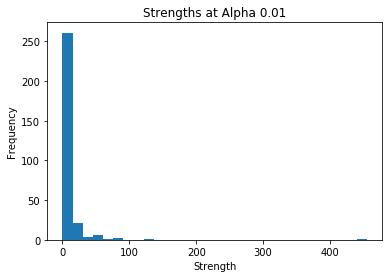

In [20]:
# C1 Strength distribution
C2_strength_sequence = []
for i in C2.nodes:
    strength = C2.degree(i, weight = 'weight')
    C2_strength_sequence.append(strength)

counts, bins, patches = plt.hist(C2_strength_sequence, bins=30)
plt.title('Strengths at Alpha 0.01')
plt.xlabel('Strength')
plt.ylabel('Frequency');

In [21]:
print('Mean strength of Alpha 0.05:', statistics.mean(C1_strength_sequence))
print('Standard deviation strength of Alpha 0.05:',statistics.stdev(C1_strength_sequence))

print('Mean strength of Alpha 0.01:', statistics.mean(C2_strength_sequence))
print('Standard deviation strength of Alpha 0.01:',statistics.stdev(C2_strength_sequence))

Mean strength of Alpha 0.05: 18.410774410774412
Standard deviation strength of Alpha 0.05: 68.57827165348615
Mean strength of Alpha 0.01: 6.922558922558922
Standard deviation strength of Alpha 0.01: 29.926216634891254


Per statistics shown above, when the alpha is smaller, the mean strength and the standard deviation strength are both smaller.

### Q3. Build a random network with 1,000 nodes and p = 0.002. Plot its degree distribution. (Hint: we show how to plot a distribution in the Chapter 3 Tutorial.) Answer the following questions:
1. What is the largest degree of the network?  
2. What is the mode of the distribution, i.e., the most common value of
the degree?
3. Is the network connected? If not, how many nodes are in the giant component?
4. What is the average clustering coefficient? Compare it with the link
probability p.
5. What is the network diameter?



In [22]:
G = nx.gnp_random_graph(1000, 0.002)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 1029
Average degree:   2.0580


In [23]:
highest_degree_node = max(G.nodes, key=G.degree)
print("The largest degree is", G.degree(highest_degree_node))

The largest degree is 9


In [24]:
degree_sequence = [G.degree(n) for n in G.nodes]
from collections import Counter
degree_counts = Counter(degree_sequence)

print("The most common value of the degree is and its frequency are", degree_counts.most_common(1))

The most common value of the degree is and its frequency are [(2, 289)]


In [25]:
nx.is_connected(G)

False

The network is not connected

In [26]:
comps = sorted(nx.connected_components(G), key = len, reverse = True)
nodes_in_giant_comp = comps[0]
print("The number of nodes are in the giant component is", len(nodes_in_giant_comp))

The number of nodes are in the giant component is 817


In [27]:
print("The average clustering coefficient is ", nx.average_clustering(G))

The average clustering coefficient is  0.0


In [28]:
p = 0.002
nx.average_clustering(G) < p

True

The average clustering coefficient is smaller than p

In [29]:
# Get the giant component diameter
GC = nx.subgraph(G, nodes_in_giant_comp)
print("The giant component diameter is:", nx.diameter(GC))

The giant component diameter is: 22


### Q4. Consider the following process. 
First, start with a collection of N nodes and no links. This is clearly a disconnected network. Then, one by one, add a link between two nodes not already connected to each other. Continue until you have a complete network. **How many steps are in this process?**


A fully connected network is a network topology in which there is a direct link between all pairs of nodes. In a fully connected network with n nodes, there are n(n-1)/2 direct links. Therefore we will need add N(N-1)/2 direct links in this process

### Q5. Reproduce the plot of Figure 5.2 (see NetSci textbook p144) for networks with 1,000 nodes.
(Hint: use the NetworkX function to generate random networks.)   
Use 25 equally-spaced values of the link probability, in the interval [0, 0.005]. For each value generate 20 different networks, compute the relative size of the giant component and report the average and the standard deviation in the plot.

In [30]:
p_list = list(np.arange(0.0002, 0.0052, 0.0002))
print(p_list)

[0.0002, 0.0004, 0.0006000000000000001, 0.0008, 0.001, 0.0012000000000000001, 0.0014000000000000002, 0.0016, 0.0018000000000000002, 0.002, 0.0022, 0.0024000000000000002, 0.0026000000000000003, 0.0028000000000000004, 0.003, 0.0032, 0.0034000000000000002, 0.0036000000000000003, 0.0038000000000000004, 0.004, 0.0042, 0.0044, 0.0046, 0.0048, 0.005]


In [31]:
# create a list of relative size of the giant component with each p in interval [0, 0.005]
avg_GC_size = []
stdev_GC_size = []

for p in p_list:
    Graph_list = []
    p_GC_size_list = []
    
    # generate 20 different networks
    for i in range(20):
        G = nx.gnp_random_graph(1000, p)
        Graph_list.append(G)
        
        # get the giant component
        nodes_in_giant_comp = sorted(nx.connected_components(G), key = len, reverse = True)[0]
        relative_size = len(nodes_in_giant_comp)/len(G.nodes)
        p_GC_size_list.append(relative_size)
    
    # calculate the average of the relative size list for each p 
    ave_p_GC_size = statistics.mean(p_GC_size_list)
    ave_p_GC_size_pair = (p, ave_p_GC_size)
    avg_GC_size.append(ave_p_GC_size_pair)
    
    # calculate the stdev of the relative size list for each p 
    stdev_p_GC_size = statistics.stdev(p_GC_size_list)
    stdev_p_GC_size_pair = (p, stdev_p_GC_size)
    stdev_GC_size.append(stdev_p_GC_size_pair)

# returns a dictionary  
avg_GC_size = dict(avg_GC_size)
stdev_GC_size = dict(stdev_GC_size)

In [33]:
print(avg_GC_size)

{0.0002: 0.00485, 0.0004: 0.00815, 0.0006000000000000001: 0.01735, 0.0008: 0.032, 0.001: 0.1032, 0.0012000000000000001: 0.29355, 0.0014000000000000002: 0.52355, 0.0016: 0.6355, 0.0018000000000000002: 0.73305, 0.002: 0.79285, 0.0022: 0.84375, 0.0024000000000000002: 0.88055, 0.0026000000000000003: 0.9079, 0.0028000000000000004: 0.92615, 0.003: 0.94145, 0.0032: 0.94895, 0.0034000000000000002: 0.9633999999999999, 0.0036000000000000003: 0.9696, 0.0038000000000000004: 0.9749, 0.004: 0.9814499999999999, 0.0042: 0.9852, 0.0044: 0.98685, 0.0046: 0.9904999999999999, 0.0048: 0.9908, 0.005: 0.9931}


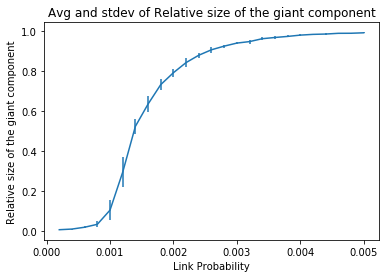

In [32]:
# report the average and the standard deviation in the plot
x = avg_GC_size.keys()
y = avg_GC_size.values()
yerr = stdev_GC_size.values()
plt.errorbar(x, y, yerr=yerr)
plt.xlabel('Link Probability')
plt.ylabel('Relative size of the giant component')
plt.title('Avg and stdev of Relative size of the giant component');